In [1]:
import importlib
import reservoirpy.nodes as nodes
import reservoirpy as rpy
from reservoirpy.datasets import lorenz
import custom_node
import numpy as np
import matplotlib.pyplot as plt
importlib.reload(custom_node)
rpy.set_seed(42)  
%matplotlib inline

In [2]:
X = lorenz(2000)

# Normalizing Series in the range of [-1,1]
X_min, X_max = X.min(), X.max()
X_norm_01 = (X - X_min) / (X_max - X_min)
X_norm_final = 2 * X_norm_01 - 1

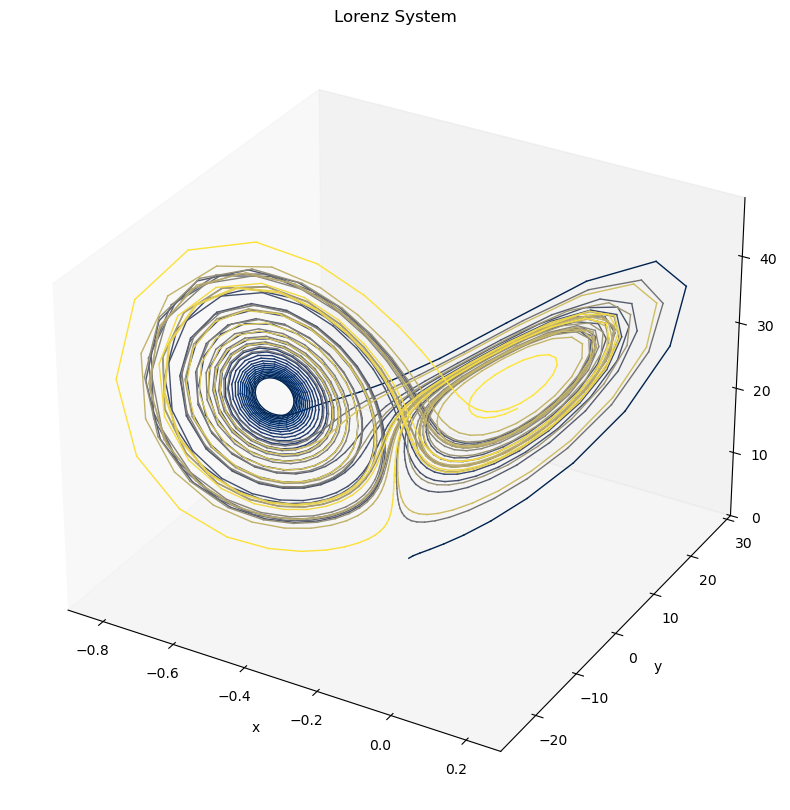

In [3]:
timesteps = 2000
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Lorenz System")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.grid(False)

for i in range(timesteps-1):
    ax.plot(X_norm_final[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//timesteps), lw=1.0)
plt.show()

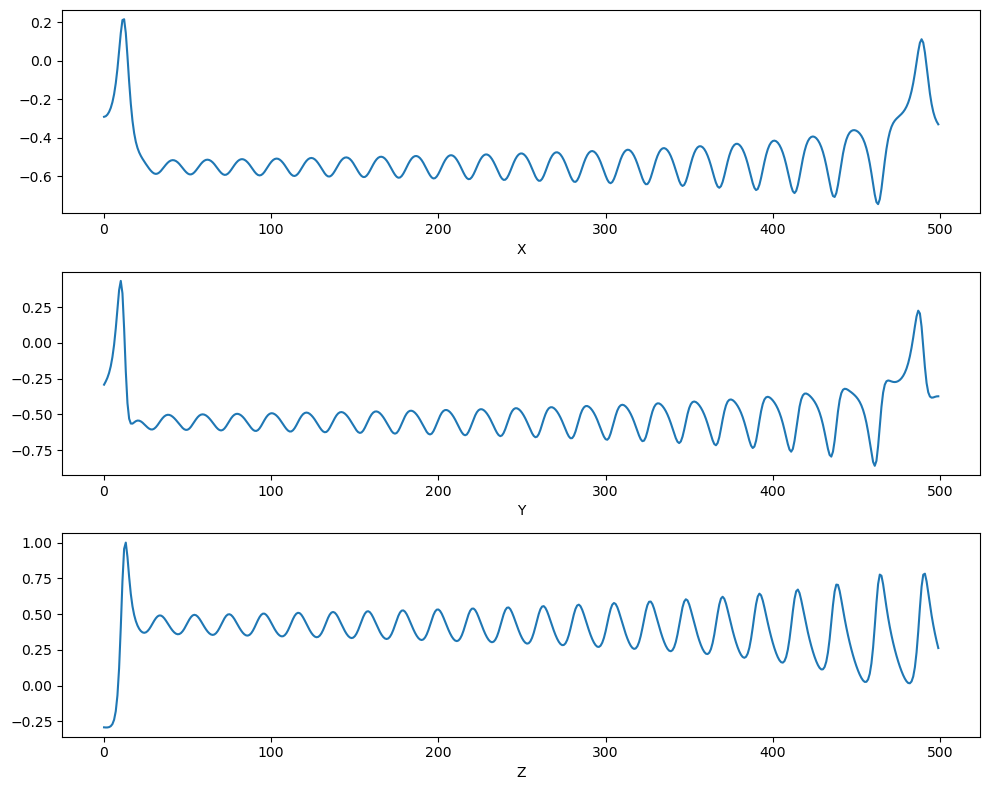

In [4]:
fig, axes = plt.subplots(3,1, figsize=(10, 8))

axes[0].plot(X_norm_final[:500, 0])
axes[1].plot(X_norm_final[:500, 1])
axes[2].plot(X_norm_final[:500, 2])

axes[0].set_xlabel("X")
axes[1].set_xlabel("Y")
axes[2].set_xlabel("Z")

plt.tight_layout()
plt.show()

In [5]:
X_train = X_norm_final[:1500, :]
Y_train = X_norm_final[1:1501, :]

In [6]:
standard = custom_node.StandardTanhNeuron(50, lr=0.3)
data = nodes.Input()

readout1 = nodes.Ridge(ridge=0.7, name="readout1-1")
readout2 = nodes.Ridge(ridge=0.7, name="readout1-2")
readout3 = nodes.Ridge(ridge=0.7, name="readout1-3")
standard_readout = [readout1, readout2, readout3]

standard_model = data >> standard >> standard_readout

# Standard TanH ESN

In [7]:
standard_model.fit(
    X_train, 
    {
        "readout1-1": Y_train[:,0][:, np.newaxis],
        "readout1-2": Y_train[:,1][:, np.newaxis],
        "readout1-3": Y_train[:,2][:, np.newaxis]
    }
)

Model(Input(), StandardTanhNeuron(), Ridge(ridge:0.7, input_dim:50, output_dim:1, name:readout1-1), Ridge(ridge:0.7, input_dim:50, output_dim:1, name:readout1-2), Ridge(ridge:0.7, input_dim:50, output_dim:1, name:readout1-3))

In [8]:
standard_state = standard.state['out']

In [9]:
Y_pred_5 = np.empty((3, 5))
x = Y_train[-1].copy().reshape(1,3)
STATE_pred_5 = np.empty((5, 50))
for i in range(5):
    # print(x)
    output = standard_model.run(x)
    STATE_pred_5[i, :] = standard.state["out"]
    

    Y_pred_5[0,i] = output['readout1-1'].squeeze()
    Y_pred_5[1,i] = output['readout1-2'].squeeze()
    Y_pred_5[2,i] = output['readout1-3'].squeeze()
    x = Y_pred_5[:, i].reshape(1,3)

In [10]:
np.sqrt(np.sum((X_norm_final[1500:1505]-Y_pred_5.T)**2)/5)

np.float64(0.2606993123340385)

## Plots

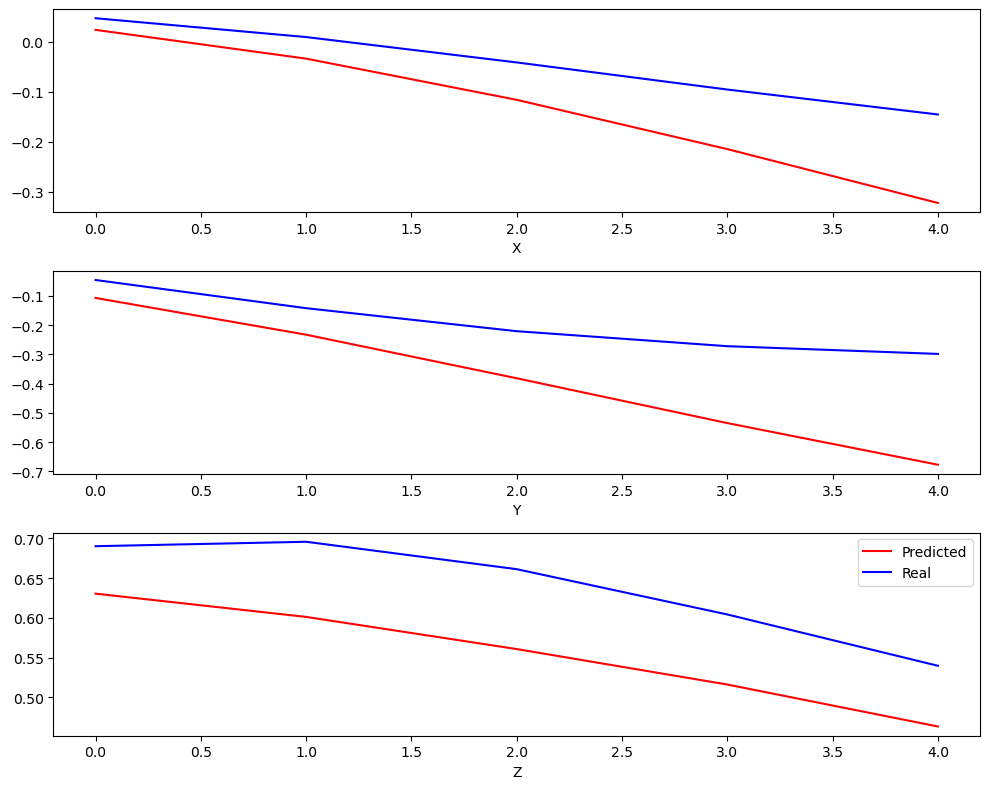

In [11]:
fig, axes = plt.subplots(3,1, figsize=(10, 8))

axes[0].plot(Y_pred_5[0,:], label = "Predicted", color="red")
axes[1].plot(Y_pred_5[1,:], label = "Predicted", color="red")
axes[2].plot(Y_pred_5[2,:], label = "Predicted", color="red")
axes[0].plot(X_norm_final[1500:1505, 0], label = "Real", color="blue")
axes[1].plot(X_norm_final[1500:1505, 1], label = "Real", color="blue")
axes[2].plot(X_norm_final[1500:1505, 2], label = "Real", color="blue")

axes[0].set_xlabel("X")
axes[1].set_xlabel("Y")
axes[2].set_xlabel("Z")

plt.legend()
plt.tight_layout()
plt.show()

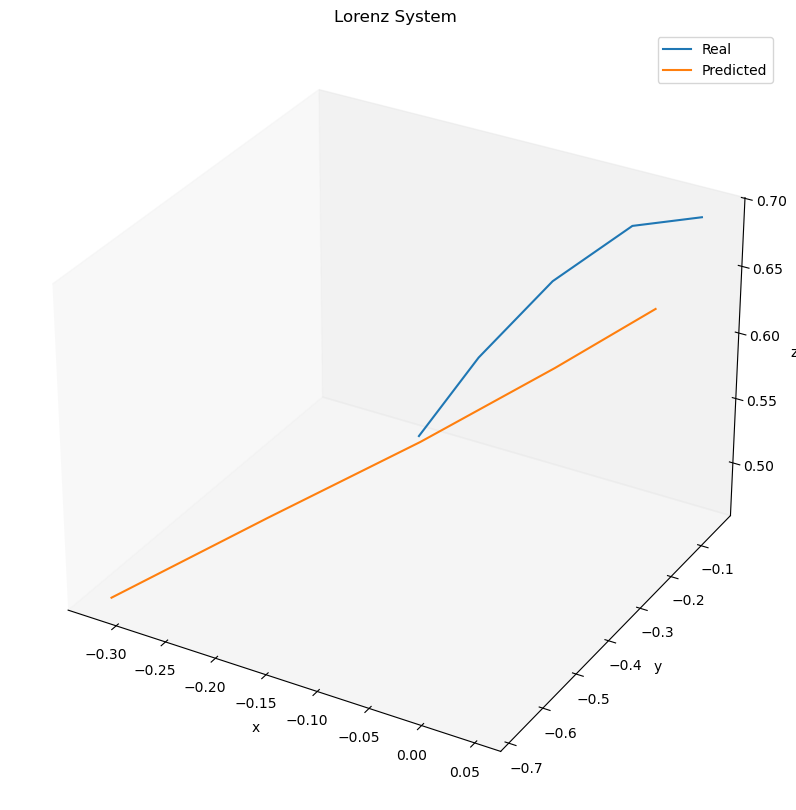

In [12]:
timesteps = 2000
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Lorenz System")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.grid(False)

ax.plot(X_norm_final[1500:1505, 0], X_norm_final[1500:1505, 1], X_norm_final[1500:1505, 2], label="Real")
ax.plot(Y_pred_5[0,:], Y_pred_5[1,:], Y_pred_5[2,:], label="Predicted")

plt.legend()
plt.show()

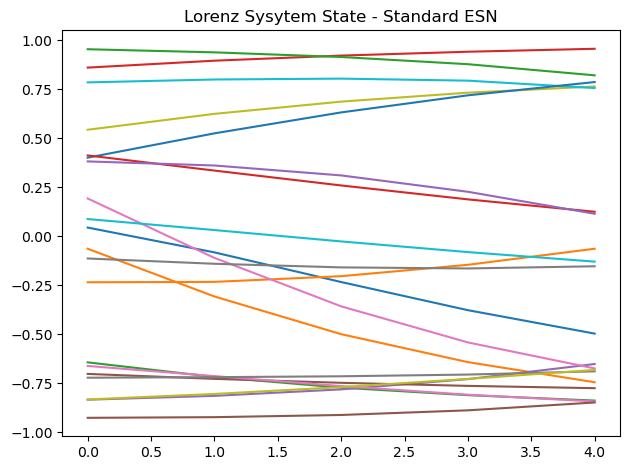

In [13]:
plt.plot(STATE_pred_5[:, :20])
plt.title(f"Lorenz Sysytem State - Standard ESN")


# plt.legend()
plt.tight_layout()
plt.show()

# ELM Neuron

In [33]:
elm = custom_node.ELMNeuron(50, fast_decay=0.5, slow_decay=0.3, seed=42)

elm_readout1 = nodes.Ridge(ridge=0.7, name="readout1-1")
elm_readout2 = nodes.Ridge(ridge=0.7, name="readout1-2")
elm_readout3 = nodes.Ridge(ridge=0.7, name="readout1-3")
elm_readout = [elm_readout1, elm_readout2, elm_readout3]

elm_model = data >> elm >> elm_readout

In [34]:
trained_elm = elm_model.fit(
    X_train, 
    {
        "readout1-1": Y_train[:,0][:, np.newaxis],
        "readout1-2": Y_train[:,1][:, np.newaxis],
        "readout1-3": Y_train[:,2][:, np.newaxis]
    }
)

In [35]:
elm_state = elm.state['out']
elm_state.shape

(50,)

In [36]:
Y_pred_5_elm = np.empty((3, 5))
x = Y_train[-1].copy().reshape(1,3)
STATE_pred_5_elm = np.empty((5, 50))
for i in range(5):
    # print(x)
    output = elm_model.run(x)
    STATE_pred_5_elm[i, :] = elm.state["out"]
    

    Y_pred_5_elm[0,i] = output['readout1-1'].squeeze()
    Y_pred_5_elm[1,i] = output['readout1-2'].squeeze()
    Y_pred_5_elm[2,i] = output['readout1-3'].squeeze()
    x = Y_pred_5_elm[:, i].reshape(1,3)

In [37]:
np.sqrt(np.sum((X_norm_final[1500:1505]-Y_pred_5_elm.T)**2)/5)

np.float64(0.40535484962093077)

## Plots

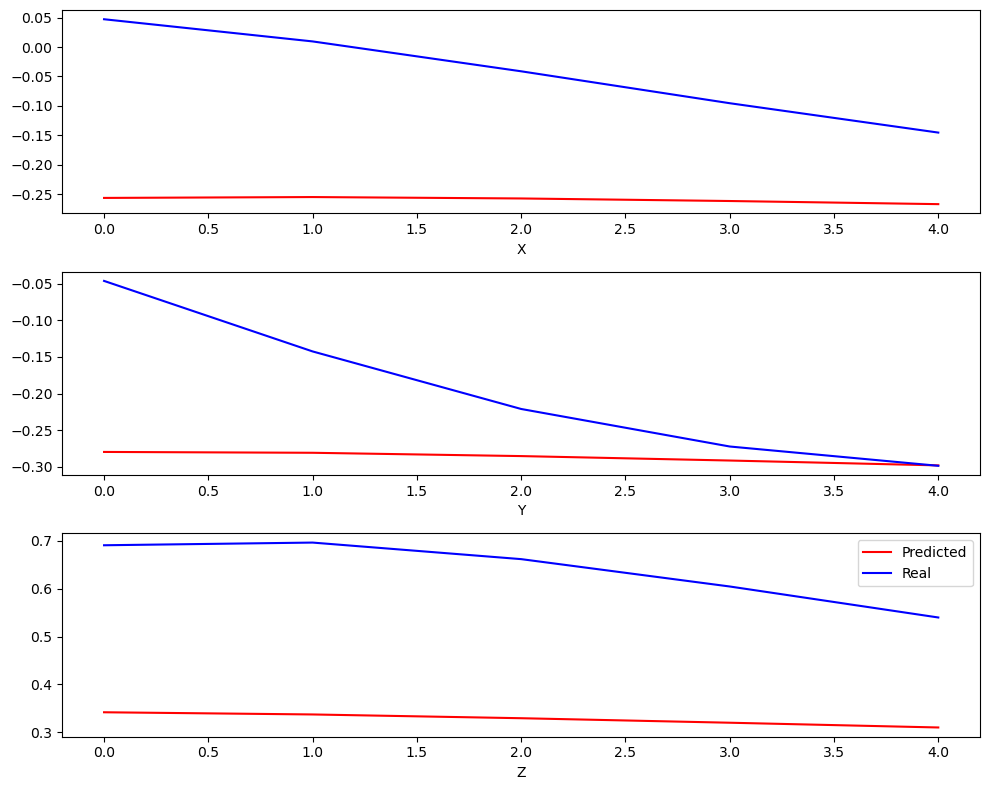

In [38]:
fig, axes = plt.subplots(3,1, figsize=(10, 8))

axes[0].plot(Y_pred_5_elm[0,:], label = "Predicted", color="red")
axes[1].plot(Y_pred_5_elm[1,:], label = "Predicted", color="red")
axes[2].plot(Y_pred_5_elm[2,:], label = "Predicted", color="red")
axes[0].plot(X_norm_final[1500:1505, 0], label = "Real", color="blue")
axes[1].plot(X_norm_final[1500:1505, 1], label = "Real", color="blue")
axes[2].plot(X_norm_final[1500:1505, 2], label = "Real", color="blue")

axes[0].set_xlabel("X")
axes[1].set_xlabel("Y")
axes[2].set_xlabel("Z")

plt.legend()
plt.tight_layout()
plt.show()

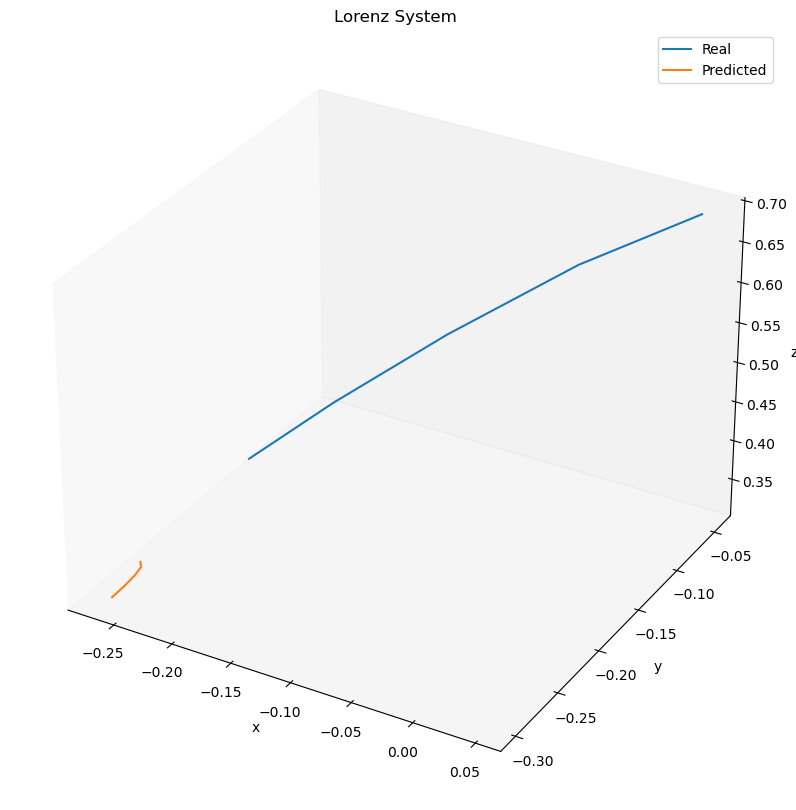

In [39]:
timesteps = 2000
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Lorenz System")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.grid(False)

ax.plot(X_norm_final[1500:1505, 0], X_norm_final[1500:1505, 1], X_norm_final[1500:1505, 2], label="Real")
ax.plot(Y_pred_5_elm[0,:], Y_pred_5_elm[1,:], Y_pred_5_elm[2,:], label="Predicted")

plt.legend()
plt.show()

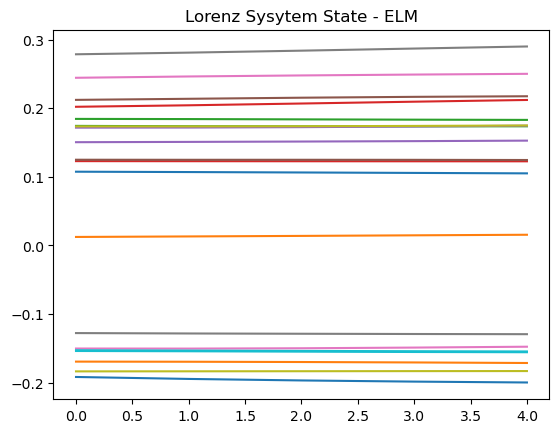

In [40]:
plt.plot(STATE_pred_5_elm[:,:20])
plt.title(f"Lorenz Sysytem State - ELM")
plt.show()

# Calcitron Neuron

In [22]:
calcitron = custom_node.CalcitronNeuron(3) # size SHOULD be equal to the dimnesion of the input

calcitron_readout1 = nodes.Ridge(ridge=0.7, name="readout1-1")
calcitron_readout2 = nodes.Ridge(ridge=0.7, name="readout1-2")
calcitron_readout3 = nodes.Ridge(ridge=0.7, name="readout1-3")
calcitron_readout = [calcitron_readout1, calcitron_readout2, calcitron_readout3]

calcitron_model = data >> calcitron >> calcitron_readout

In [23]:
trained_calcitron = calcitron_model.fit(
    X_train, 
    {
        "readout1-1": Y_train[:,0][:, np.newaxis],
        "readout1-2": Y_train[:,1][:, np.newaxis],
        "readout1-3": Y_train[:,2][:, np.newaxis]
    }
)

In [24]:
Y_pred_5 = np.empty((3, 5))
x = Y_train[-1].copy().reshape(1,3)
STATE_pred_5_calcitron = np.empty((5, 3))
for i in range(5):
    # print(x)
    output = calcitron_model.run(x)
    STATE_pred_5_calcitron[i, :] = calcitron.state["out"]
    

    Y_pred_5[0,i] = output['readout1-1'].squeeze()
    Y_pred_5[1,i] = output['readout1-2'].squeeze()
    Y_pred_5[2,i] = output['readout1-3'].squeeze()
    x = Y_pred_5[:, i].reshape(1,3)

In [25]:
np.sqrt(np.sum((X_norm_final[1500:1505]-Y_pred_5.T)**2)/5)

np.float64(0.21860602535401893)

## Plots

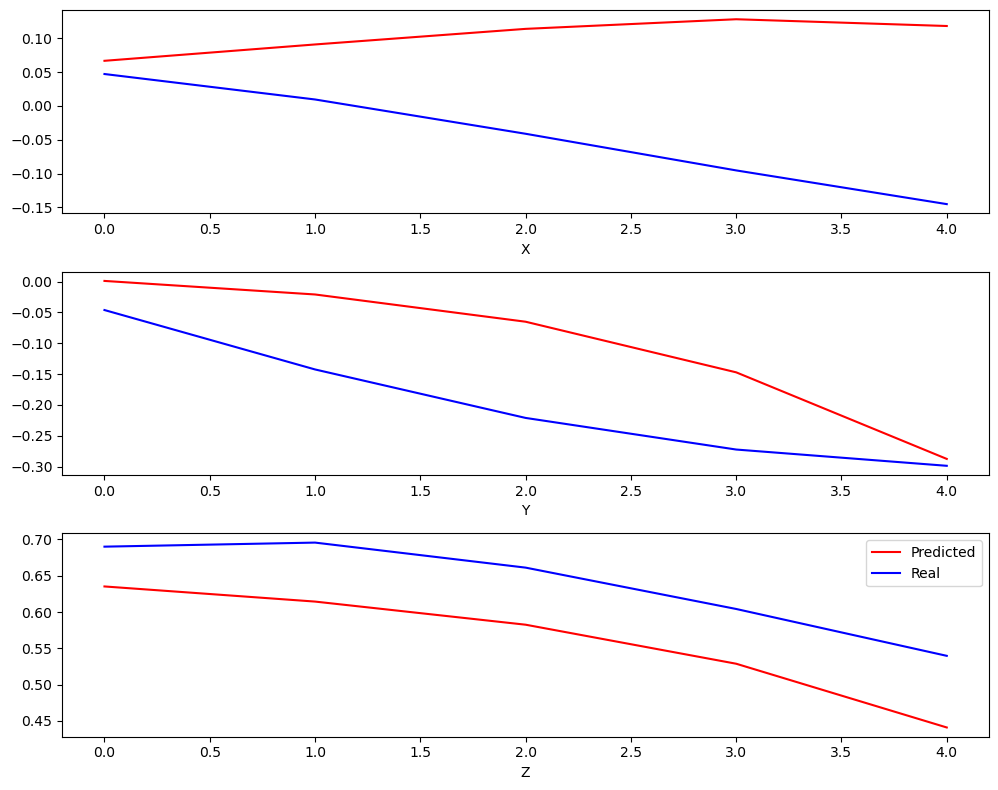

In [26]:
fig, axes = plt.subplots(3,1, figsize=(10, 8))

axes[0].plot(Y_pred_5[0,:], label = "Predicted", color="red")
axes[1].plot(Y_pred_5[1,:], label = "Predicted", color="red")
axes[2].plot(Y_pred_5[2,:], label = "Predicted", color="red")
axes[0].plot(X_norm_final[1500:1505, 0], label = "Real", color="blue")
axes[1].plot(X_norm_final[1500:1505, 1], label = "Real", color="blue")
axes[2].plot(X_norm_final[1500:1505, 2], label = "Real", color="blue")

axes[0].set_xlabel("X")
axes[1].set_xlabel("Y")
axes[2].set_xlabel("Z")

plt.legend()
plt.tight_layout()
plt.show()

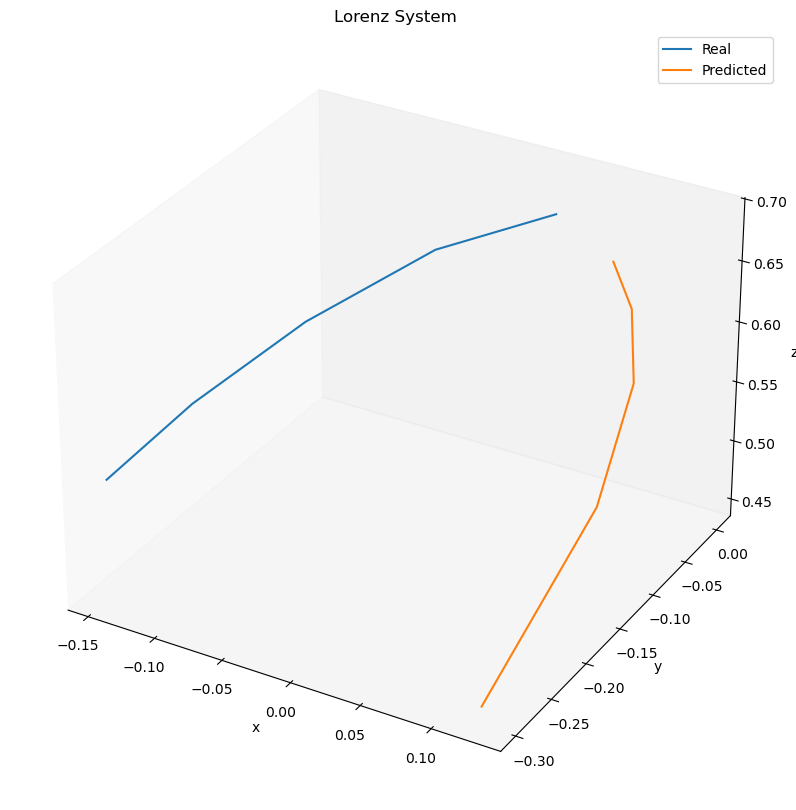

In [27]:
timesteps = 2000
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Lorenz System")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.grid(False)

ax.plot(X_norm_final[1500:1505, 0], X_norm_final[1500:1505, 1], X_norm_final[1500:1505, 2], label="Real")
ax.plot(Y_pred_5[0,:], Y_pred_5[1,:], Y_pred_5[2,:], label="Predicted")

plt.legend()
plt.show()

In [ ]:
plt.plot(STATE_pred_5_calcitron[:,0])
plt.plot(STATE_pred_5_calcitron[:,1])
plt.plot(STATE_pred_5_calcitron[:,2])
plt.title(f"Lorenz Sysytem State - Calcitron ESN")

plt.tight_layout()
plt.show()